In [185]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import cvxpy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb
import os


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



In [130]:
np.random.seed(42)

In [131]:

def quadform_grad(A, x, mu):  # Complexity of 1st oracle is n + n^2
    return A @ (x - mu) * 2

In [132]:

def atom_quadform_grad(A, x, mu, i):
    return np.dot(A[:, i], x - mu) * 2

In [133]:

def constraint_grad(x):
    return 2 * x

In [134]:

def project_to_constraint(x):
    x_norm = np.linalg.norm(x)
    return x if x_norm <= 1 else x / x_norm

In [135]:

def is_kkt_optimal(grad_obj, grad_constraint, eps=0.01):

    dot = np.dot(-grad_obj, grad_constraint)
    norm_f = np.linalg.norm(grad_obj)
    norm_g = np.linalg.norm(grad_constraint)
    if norm_f < eps or norm_g < eps:
        return True
    cos_angle = dot / (norm_f * norm_g)

    return bool((np.abs(cos_angle - 1) < eps).all())

In [136]:

def solve_elipsoid(A, mu):

    x = cp.Variable(A.shape[0])

    objective = cp.Minimize(cp.quad_form(x - mu, A))

    constraints = [cp.norm2(x) <= 1]

    prob = cp.Problem(objective, constraints)

    result = prob.solve()

    return x.value, result

In [137]:

def str_cvx_gd_solve_elipsoid(
    A, mu, x_init, f_star, eps=0.01, max_iters=30000, return_history=False
):

    alpha = np.min(np.linalg.eigvals(A * 2))

    lr = 2 / alpha

    x = x_init.copy()

    iterations = 0
    operations = 0

    precision_history = [(x - mu).T @ A @ (x - mu) - f_star]

    while iterations < max_iters:

        grad = quadform_grad(A, x, mu)
        operations += A.shape[0] ** 2 + A.shape[0] * (A.shape[0] - 1) # количество операций при подсчете градиента
        x_new = project_to_constraint(x - lr / (iterations + 1) * grad)
        operations += len(x) # количество операций при обновлении x
        f_val = (x_new - mu).T @ A @ (x_new - mu)

        x = x_new
        iterations += 1

        precision_history.append(abs(f_val - f_star))

        if abs(f_val - f_star) <= eps:
            break

    if return_history:
        return x_new, iterations, f_val, precision_history

    return x_new, f_val, iterations, operations

In [138]:
def str_cvx_sgd_solve_elipsoid(
    A,
    mu,
    x_init,
    f_star,
    dim_sample_ratio="single", # MAY BE FLOAT in (0, 1]
    eps=0.01,
    max_iters=30000,
    return_history=False,
):

    n_dims = len(mu)

    if dim_sample_ratio == "single":
        m_dims = 1

    else:
        m_dims = int(dim_sample_ratio * n_dims)

    dim_sample_ratio = m_dims/n_dims

    alpha = np.min(np.linalg.eigvals(A * 2))

    lr = 2 / (alpha*dim_sample_ratio)

    x_new = x_init.copy()

    iterations = 0
    operations = 0

    precision_history = [(x_new - mu).T @ A @ (x_new - mu) - f_star]

    while iterations < max_iters:

        step_lr = lr / (iterations + 1)

        sampled_dims = np.random.choice(n_dims, size=m_dims, replace=False)
        
        grad = 2 * A[sampled_dims, :] @ (x_new - mu)
        operations += n_dims * m_dims + (n_dims - 1) * m_dims # количество операций при подсчете градиента
        x_new[sampled_dims] -= step_lr * grad
        operations += m_dims # количество операций при обновлении x
        # for i in sampled_dims:
        #     x_new[i] -= step_lr * atom_quadform_grad(A, x_new, mu, i)

        x_new = project_to_constraint(x_new)

        f_val = (x_new - mu).T @ A @ (x_new - mu)

        x = x_new
        iterations += 1

        precision_history.append(abs(f_val - f_star))

        if abs(f_val - f_star) <= eps:
            break

    if return_history:
        return x_new, f_val, iterations, operations, precision_history

    return x_new, f_val, iterations, operations

In [139]:

def rand_elipsoids_sol_stats_gd(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    cases = []

    for i, A in enumerate(affine_ops):

        solution = solve_elipsoid(A, mu)

        eig_vigals = np.linalg.eigvals(A)
        conditional_number = max(eig_vigals) / min(eig_vigals)


        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            start_time = time.time()
            x_opt, f_val, iters, operations = str_cvx_gd_solve_elipsoid(A, mu, x_init, solution[-1], eps=eps)
            time_elapsed = time.time() - start_time
            
            cases.append({
                "n_dims": n_dim,
                "example_id" : i,
                "conditional_number": conditional_number,
                "Lipschitz_L" : max(eig_vigals),
                "strong_convexity_alpha": min(eig_vigals)*2,
                "is_kkt_optimal": is_kkt_optimal(quadform_grad(A, x_opt, mu), constraint_grad(x_opt)),
                "solution_delta": np.abs(solution[-1] - f_val),
                "iters" : iters,
                "time": time_elapsed,
                "operations": operations
            })

    return pd.DataFrame.from_records(cases)

In [140]:

def rand_elipsoids_sol_stats_sgd(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, dim_sample_ratio = "single",random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    cases = []

    if dim_sample_ratio == "single":
        m_dims = 1

    else:
        m_dims = int(dim_sample_ratio * n_dim)

    for i, A in enumerate(affine_ops):

        solution = solve_elipsoid(A, mu)

        eig_vigals = np.linalg.eigvals(A)
        conditional_number = max(eig_vigals) / min(eig_vigals)


        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            start_time = time.time()
            x_opt, f_val, iters, operations = str_cvx_sgd_solve_elipsoid(A, mu, x_init, solution[-1], dim_sample_ratio, eps=eps)
            time_elapsed = time.time() - start_time

            cases.append({
                "n_dims": n_dim,
                "example_id" : i,
                "conditional_number": conditional_number,
                "Lipschitz_L" : max(eig_vigals),
                "strong_convexity_alpha": min(eig_vigals)*2,
                "is_kkt_optimal": is_kkt_optimal(quadform_grad(A, x_opt, mu), constraint_grad(x_opt)),
                "solution_delta": np.abs(solution[-1] - f_val),
                "iters" : iters,
                "time": time_elapsed,
                "m_dims": m_dims,
                "dim_sample_ratio": dim_sample_ratio,
                "operations": operations
            })

    return pd.DataFrame.from_records(cases)

In [174]:
n_samples = 30
random_states = np.random.randint(0, 4294967295, size=n_samples)

In [177]:

def make_gd_full_stats(n_dims = None):

    if n_dims is None:
        n_dims = range(10, 110, 10)

    df_l = []
    print('-------------------------')
    for n in n_dims:
        print(f'Dim: {n}')
        print('-------------------------')
        df_l.append(rand_elipsoids_sol_stats_gd(n, n_samples=30, n_init_states=30, random_states=random_states))

    return pd.concat(df_l)

In [178]:
def make_sgd_full_stats(n_dims = None, m_ratios = None):

    if n_dims is None:
        n_dims = range(10, 110, 10)

    if m_ratios is None:
        m_ratios = ["single", 1/8, 1/4, 1/2, 1]
        # m_ratios = [1]

    df_l = []

    print('-------------------------')
    for n in n_dims:
        for r in m_ratios:
            print(f'Dim: {n} Ratio: {r}')
            df_l.append(rand_elipsoids_sol_stats_sgd(n_dim=n, dim_sample_ratio=r, n_samples=30, n_init_states=30, random_states=random_states))
            # print(f'Appended df of length {len(df_l[-1])}')
        print('-------------------------')

    return pd.concat(df_l)

In [ ]:
# gd_stats = make_gd_full_stats([2, 4])
if os.path.exists('sgd_stats_30_30.csv'):
    sgd_stats = pd.read_csv('sgd_stats_30_30.csv')
else:
    sgd_stats = make_sgd_full_stats()
    sgd_stats.to_csv('sgd_stats_30_30.csv')

-------------------------
Dim: 10 Ratio: single
Dim: 10 Ratio: 0.125
Dim: 10 Ratio: 0.25
Dim: 10 Ratio: 0.5
Dim: 10 Ratio: 1
-------------------------
Dim: 20 Ratio: single
Dim: 20 Ratio: 0.125
Dim: 20 Ratio: 0.25
Dim: 20 Ratio: 0.5
Dim: 20 Ratio: 1
-------------------------
Dim: 30 Ratio: single
Dim: 30 Ratio: 0.125
Dim: 30 Ratio: 0.25
Dim: 30 Ratio: 0.5
Dim: 30 Ratio: 1
-------------------------
Dim: 40 Ratio: single
Dim: 40 Ratio: 0.125
Dim: 40 Ratio: 0.25
Dim: 40 Ratio: 0.5
Dim: 40 Ratio: 1
-------------------------
Dim: 50 Ratio: single
Dim: 50 Ratio: 0.125
Dim: 50 Ratio: 0.25
Dim: 50 Ratio: 0.5
Dim: 50 Ratio: 1
-------------------------
Dim: 60 Ratio: single
Dim: 60 Ratio: 0.125
Dim: 60 Ratio: 0.25
Dim: 60 Ratio: 0.5
Dim: 60 Ratio: 1
-------------------------
Dim: 70 Ratio: single
Dim: 70 Ratio: 0.125
Dim: 70 Ratio: 0.25
Dim: 70 Ratio: 0.5
Dim: 70 Ratio: 1
-------------------------
Dim: 80 Ratio: single
Dim: 80 Ratio: 0.125
Dim: 80 Ratio: 0.25
Dim: 80 Ratio: 0.5
Dim: 80 Ratio: 1


In [ ]:
if os.path.exists('gd_stats_30_30.csv'):
    gd_stats = pd.read_csv('gd_stats_30_30.csv')
else:
    gd_stats = make_gd_full_stats()
    gd_stats.to_csv('gd_stats_30_30.csv')

-------------------------
Dim: 10
-------------------------
Dim: 20
-------------------------
Dim: 30
-------------------------
Dim: 40
-------------------------
Dim: 50
-------------------------
Dim: 60
-------------------------
Dim: 70
-------------------------
Dim: 80
-------------------------
Dim: 90
-------------------------
Dim: 100
-------------------------


In [186]:
sgd_stats_agg = sgd_stats.groupby(by=['n_dims', 'dim_sample_ratio']).mean().reset_index()

In [187]:
gd_stats_agg = gd_stats.groupby('n_dims').mean().reset_index()

In [188]:
max_iters = 30000
plot_data = []
for ratio in sgd_stats_agg['dim_sample_ratio'].unique():
    plot_data.append({'ratio': ratio,
                      'operations': list(sgd_stats_agg[sgd_stats_agg['dim_sample_ratio'] == ratio]['operations']),
                      'is_max_iters': list(sgd_stats_agg[sgd_stats_agg['dim_sample_ratio'] == ratio]['iters'] == max_iters)})

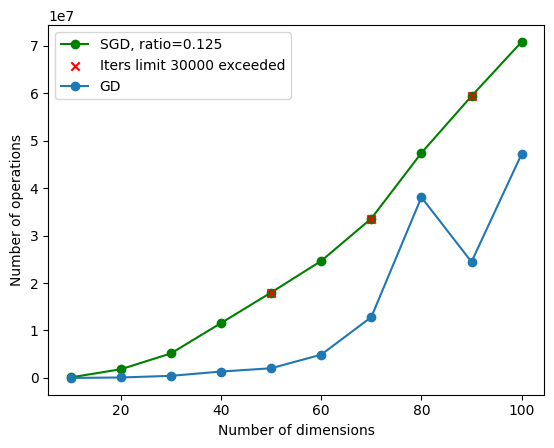

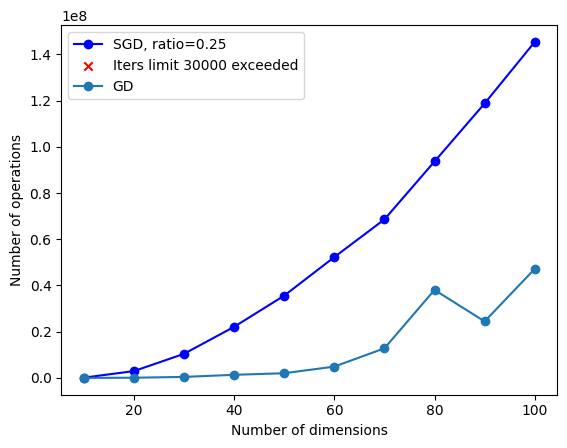

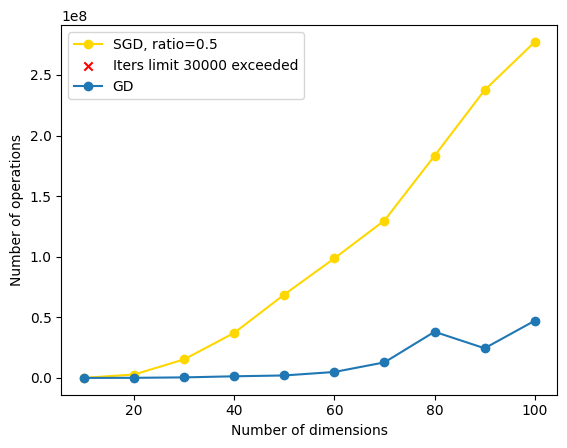

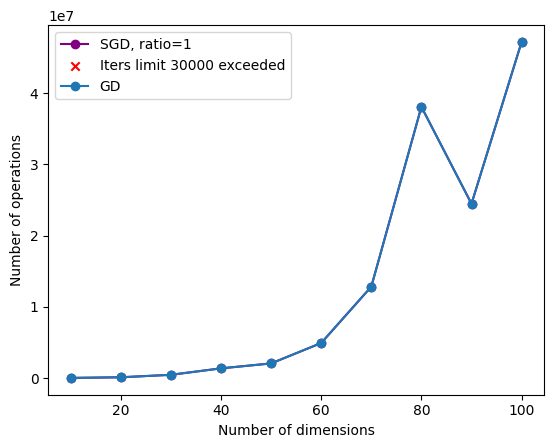

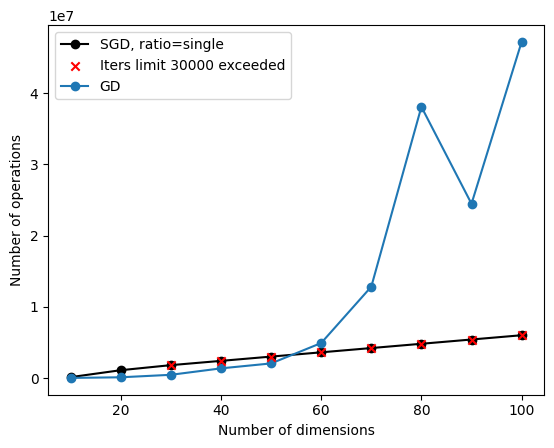

In [189]:
dims = np.array(list(range(10, 110, 10)))
colors = ['green', 'blue', 'gold', 'purple', 'black']
for i, sample in enumerate(plot_data):
    ratio = sample['ratio']
    ops = np.array(sample['operations'])
    mask = np.array(sample['is_max_iters'])
    plt.plot(dims, ops, marker='o', color=colors[i], label=f'SGD, ratio={ratio}')
    # Выделяем красным точки, где is_max_iters == True
    plt.scatter(dims[mask], ops[mask], color='red', zorder=5, marker='x', label=f'Iters limit {max_iters} exceeded')
    plt.plot(gd_stats_agg['n_dims'], gd_stats_agg['operations'], marker='o', label=f'GD')
    plt.legend()

    plt.xlabel('Number of dimensions')
    plt.ylabel('Number of operations')
    plt.show()